# Coefficients

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/HugoMVale/polykin/main?labpath=docs%2Ftutorials%2Fcoefficients.ipynb)

## Overview

The `coefficients` module offers a number of classes to deal with the types of kinetic coefficients and physical property correlations most often found in polymer reactor models.

| Class                     | Required arguments | Optional arguments                    | Category               |
|---------------------------|--------------------|---------------------------------------|------------------------|
| Arrhenius                 | k0, EaR            | T0, Tmin, Tmax, unit, symbol, name    | kinetics (generic)     |
| Eyring                    | DSa, DHa           | kappa, Tmin, Tmax,  symbol, name      | kinetics (generic)     |
| PropagationHalfLength     | kp                 | C, ihalf, name                        | kinetics (propagation) |
| TerminationCompositeModel | k11, icrit         | aS, aL, name                          | kinetics (termination) |
| DIPPR100                  | A, B, C, D, E      | Tmin, Tmax, unit, symbol, name        | physical properties    |
| DIPPR101                  | A, B, C, D, E      | Tmin, Tmax, unit, symbol, name        | physical properties    |
| DIPPR105                  | A, B, C, D         | Tmin, Tmax, unit, symbol, name        | physical properties    |

The meanings of all arguments, along with their corresponding units, are documented in the respective docstrings.

## Kinetic coefficients

### Arrhenius and Eyring

In [1]:
from polykin.coefficients import Arrhenius, Eyring

To instantiate a kinetic coefficient, we call the respective class constructor with the desired argument values. Here are some examples of Arrhenius coefficients.

In [2]:
# Arrhenius coefficient defined by pre-exponential factor (A) and Ea/R.
k1 = Arrhenius(1e10, 2e3)

# Arrhenius coefficient defined by value at reference temperature (T0) and Ea/R.
k2 = Arrhenius(1e5, 3e3, T0=350.)

# Arrhenius coefficient including temperature limits, units, symbol, and name.
k3 = Arrhenius(1e3, 1.8e3, T0=320., Tmin=283., Tmax=363., unit='L/mol/s',
               symbol='k_p', name='kp of MX')

# Array of Arrhenius coefficients.
k4 = Arrhenius([1e3, 2e3], [1.8e3, 4e3], T0=298., Tmin=273., Tmax=373.,
               symbol='k_d', unit='1/min',  name='kd(I1, I2)')

For Eyring coefficients, we proceed similarly, only with different arguments.

In [3]:
# Eyring coefficient defined by entropy and enthalpy of activation.
k5 = Eyring(1e2, 1e4)

# Eyring coefficient including transmission factor, temperature limits, and name.
k6 = Eyring(20., 1e4, kappa=0.8, Tmin=273., Tmax=373., symbol='k_6',
            name='k of A->B')

The most important properties of a coefficient can be displayed by calling the object directly.

In [4]:
k4

name:      kd(I1, I2)
symbol:    k_d
unit:      1/min
k0:        [1000. 2000.]
Ea/R [K]:  [1800. 4000.]
T0   [K]:  298.0
Tmin [K]:  273.0
Tmax [K]:  373.0

or, equivalently, by using the `print()` function.

In [5]:
print(k6)

name:             k of A->B
symbol:           k_6
unit:             1/s
DSa [J/(mol·K)]:  20.0
DHa [J/mol]:      10000.0
kappa [—]:        0.8
Tmin [K]:         273.0
Tmax [K]:         373.0


To evaluate a coefficient at a given temperature, we simply call the object with the temperature value (scalar or array-like) as the first positional argument. The temperature unit can be passed as second argument (default is °C). 

In [6]:
# Evaluate k3 at 25°C
k3(25.)

662.1722354923082

In [7]:
# Evaluate k3 at 298.15 K
k3(298.15, 'K')

662.1722354923082

In [8]:
# Evaluate k4 at 50°C
k4(50.)

array([1600.15388708, 5684.89928869])

In [9]:
# Evaluate k3 at multiple temperatures (in °C)
k5([25., 50., 75.])

array([1.83950035e+16, 2.72398134e+16, 3.83386008e+16])

Evaluations outside the specified temperature range are allowed, but raise a warning.

In [10]:
k6(110.)

3066834199862.7715

Arrhenius coefficients have the special mathematical property that a product or quotient of two Arrhenius coefficients is also an Arrhenius coefficient. The `Arrhenius` class overloads the `*` and `/` operators to consider this intrisic feature.

In [11]:
kp1 = Arrhenius(1e3, 2e3, T0 = 350., symbol='k_{p1}', name='kp1')
Cm1 = Arrhenius(1e-3, 1e3, T0 = 300., symbol='C_{m1}', name='Cm1')
f = Arrhenius(1., 5e2, T0 = 320., symbol='f', name='fudge factor')
kfm1 = Cm1*kp1/f

# kfm1 is now a coefficient and can be used as such
kfm1([25., 50.])

array([0.40660136, 0.77784632])

### PropagationHalfLength 

In [12]:
from polykin.coefficients import PropagationHalfLength

This class implements the chain-length-dependent $k_p$ equation proposed by [Smith et al. (2005)](https://doi.org/10.1016/j.eurpolymj.2004.09.002). Note that the class only describes the chain-length effect; the temperature effect must be described separtely (e.g., by `Arrhenius` or `Eyring`). 

In [13]:
# Long-chain kp(T)
kp = Arrhenius(10**7.63, 32.5e3/8.314, Tmin=261., Tmax=366., symbol='k_p(T)',
               unit='L/mol/s', name='kp of styrene')

# CLD-kp
kpi = PropagationHalfLength(kp, C=10, ihalf=0.5, name='kp(T,i) of Y')

In [14]:
# kp at 50°C for a trimeric radical
kpi(50, 3)

371.75986615653215

### TerminationCompositeModel

In [15]:
from polykin.coefficients import TerminationCompositeModel

This class implements the chain-length-dependent composite termination model proposed by [Smith & Russel (2003)](https://doi.org/10.1002/mats.200390029). Note that the class only describes the chain-length effect; the temperature effect must be described separtely (e.g., by `Arrhenius` or `Eyring`). 

In [16]:
# kt(T) of monomeric radicals
kt11 = Arrhenius(1e9, 2e3, T0=298., symbol='k_t(T,1,1)', unit='L/mol/s',
                 name='kt11 of Y')

# CLD-kt
ktij = TerminationCompositeModel(kt11, icrit=30, name='ktij of Y')

In [17]:
# kt at 25°C between radicals with chain lengths 150 and 200
ktij(25., 150, 200)

129008375.03821689

The internal functions are vectorized, so the arguments can also be arrays. For example, we can create a contour plot of kt with just a few lines of code.

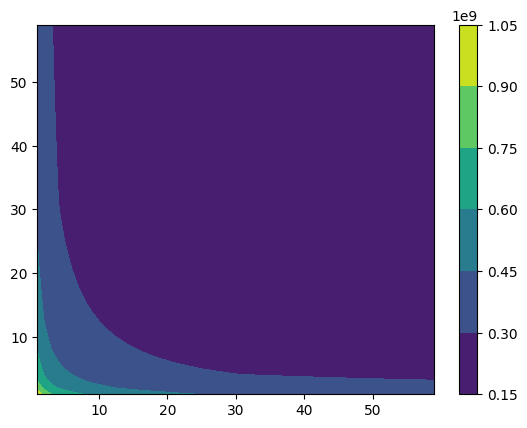

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# create mesh of chain-lengths
length_range = np.arange(1, 60)
mesh = np.meshgrid(length_range, length_range)

# evaluate kt for mesh
kt_result = ktij(25, mesh[0], mesh[1])

# make contour plot
plt.contourf(length_range, length_range, kt_result)
plt.colorbar()

## DIPPR correlations

In [19]:
from polykin.coefficients import DIPPR100, DIPPR101, DIPPR105

DIPPR equations are used to correlate a wide range of physical properties. To instantiate an object, we call the respective class constructor with the desired argument values. Here are some examples for each of the DIPPR equations presently implemented.

In [20]:
# Water Cp using DIPPR-100
Cp_water = DIPPR100(276370., -2090.1, 8.125, -0.014116, 0.0000093701,
                    unit='J/kmol/K', symbol='C_p', name='Cp of water')

# Water vapor pressure using DIPPR-101
Pvap_water = DIPPR101(73.649, -7258.2, -7.3037, 4.1653E-6, 2., unit='Pa',
                      symbol=r'P_{vap}', name='Vapor pressure of water')

# Water density using DIPPR-105
density_water = DIPPR105(0.14395, 0.0112, 649.727, 0.05107, Tmin=273.,
                         Tmax=648., unit='kg/m³', symbol=r'\rho',
                         name='Density of water')

In [21]:
Cp_water(25.)/18.02

4183.363133587069

In [22]:
Pvap_water(373.15, 'K')/1e5

1.0126056298096628

In [23]:
density_water(25.)

998.9463920931878

In [24]:
density_water

name:      Density of water
symbol:    \rho
unit:      kg/m³
A:         0.14395
B:         0.0112
C:         649.727
D:         0.05107
Tmin [K]:  273.0
Tmax [K]:  648.0

All equations are vectorized to facilitate evaluation at multiple temperatures. 

In [25]:
density_water([0., 50., 100.])

array([1014.34627215,  982.72892731,  947.3649398 ])

## Plots

`Arrhenius`, `Eyring`, and all `DIPPR` subclasses come with a convenient built-in method called `plot()`, enabling a rapid visualization of the corresponding kinetic or property models.

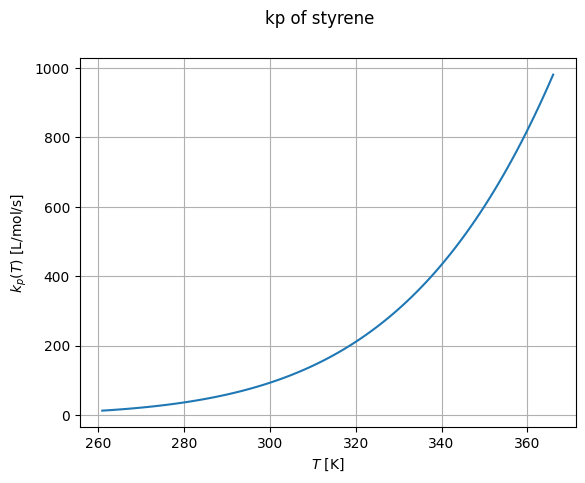

In [26]:
# Default ('linear') plot of kp over the validity range 
kp.plot(Tunit='K')

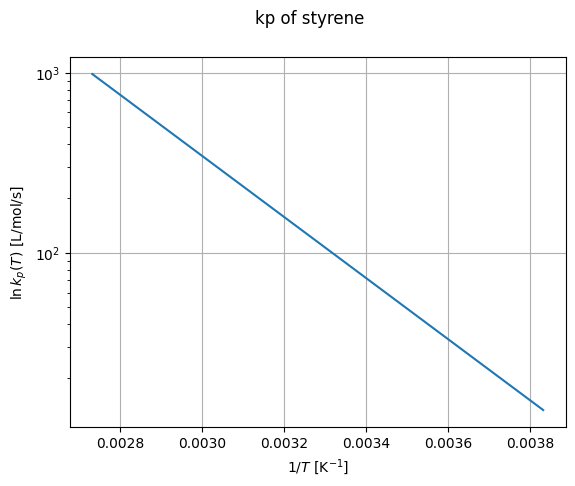

In [27]:
# Arrhenius plot of kp over the validity range 
kp.plot(kind='Arrhenius')

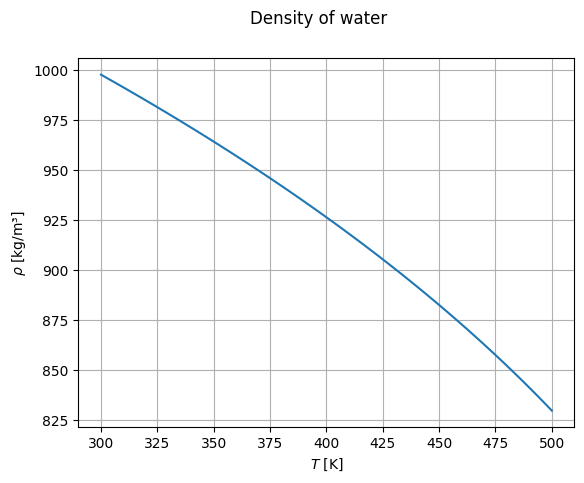

In [28]:
# plot density of water from 300-500 K
density_water.plot(Trange=(300, 500), Tunit='K')

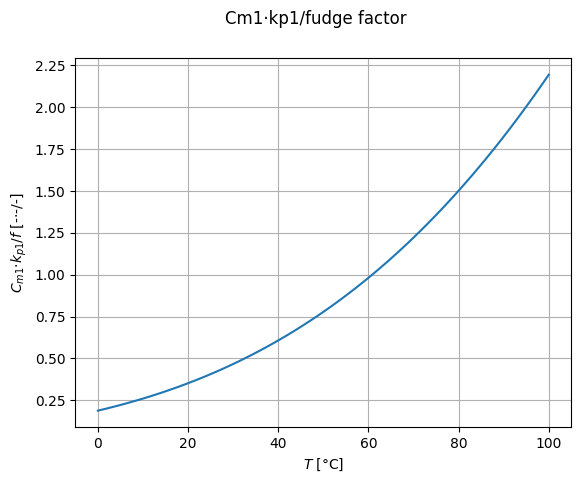

In [29]:
# If no temperature range is known, the plot range defaults to 0-100°C
kfm1.plot()

Lastly, the function `plotcoeffs()` can be used to overlay multiple distributions on the same plot. The optional keywords arguments are those of the `plot()` method. 

In [30]:
from polykin.coefficients import plotcoeffs

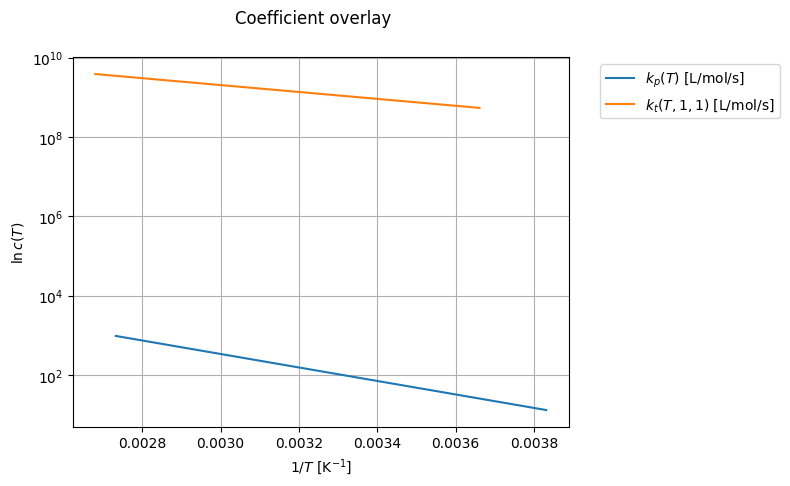

In [31]:

_ = plotcoeffs([kp, kt11], kind='Arrhenius')